In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers torchvision --quiet

from transformers import CLIPProcessor, CLIPModel, GPT2Tokenizer, GPT2LMHeadModel
from PIL import Image
import torch
import os
import pandas as pd

# 1. تحميل النماذج
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

# 2. المسار إلى الصور
image_folder = "/content/drive/MyDrive/Flickr30/Images"  # عدليه إذا غير صحيح
checkpoint_file = "/content/drive/MyDrive/Flickr30/captions_generated.csv"

# 3. تحميل الصور الجاهزة مسبقًا (checkpoint)
if os.path.exists(checkpoint_file):
    done_df = pd.read_csv(checkpoint_file)
    done_images = set(done_df["image"].tolist())
    print(f"✅ تم توليد أوصاف لـ {len(done_images)} صورة مسبقًا.")
else:
    done_df = pd.DataFrame(columns=["image", "caption"])
    done_images = set()

# 4. الصور المتوفرة في المجلد
all_images = [img for img in os.listdir(image_folder) if img.lower().endswith((".jpg", ".png"))]
remaining_images = [img for img in all_images if img not in done_images]
print(f"🔄 سيتم توليد أوصاف لـ {len(remaining_images)} صورة الآن.")

# 5. مرشّحات CLIP لتوليد السياق الأولي
clip_prompts = [
    "A dog running", "A man walking", "Children playing", "A woman smiling",
    "A group of people", "A street scene", "An animal in nature", "Someone riding a bike"
]

# 6. حلقة توليد الأوصاف
for image_name in remaining_images:
    try:
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path).convert("RGB")

        # تمرير عبر CLIP
        inputs = clip_processor(text=clip_prompts, images=image, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = clip_model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1)

        best_prompt = clip_prompts[probs[0].argmax()]
        gpt_input = f"Image Description: {best_prompt}. This is"
        tokens = gpt2_tokenizer.encode(gpt_input, return_tensors="pt")

        # توليد النص
        output = gpt2_model.generate(
            tokens,
            max_length=50,
            do_sample=True,
            top_p=0.9,
            temperature=0.9,
            repetition_penalty=1.2,
            pad_token_id=gpt2_tokenizer.eos_token_id
        )

        caption = gpt2_tokenizer.decode(output[0], skip_special_tokens=True)

        # حفظ النتيجة بالملف
        done_df = pd.concat([done_df, pd.DataFrame({"image": [image_name], "caption": [caption]})])
        done_df.to_csv(checkpoint_file, index=False)

        print(f"✅ {image_name} ➜ {caption}")

    except Exception as e:
        print(f"❌ خطأ مع الصورة {image_name}: {e}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ تم توليد أوصاف لـ 6802 صورة مسبقًا.
🔄 سيتم توليد أوصاف لـ 1289 صورة الآن.
❌ خطأ مع الصورة 1808504612_3508f3c9bb.jpg: cannot identify image file '/content/drive/MyDrive/Flickr30/Images/1808504612_3508f3c9bb.jpg'


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ 2679851489_a58780291e.jpg ➜ Image Description: A dog running. This is a real-time game of fetching, where each player moves their hand up and down the screen to complete tasks that are similar in nature but require much more effort than simply finding food for your pet(
✅ 2679926555_b11cf45595.jpg ➜ Image Description: Children playing. This is a good place to try for children and their parents, where the kids are very busy trying out new things of interest but also showing them something that they would like from each other if not in one another's company
✅ 2680619645_ab6645218d.jpg ➜ Image Description: A dog running. This is not one that has seen much activity in the past few weeks, and it will soon run out of energy as well."
1/3-4 pups - more info on pup training here!


✅ 2680990587_eee6bd04fb.jpg ➜ Image Description: Children playing. This is one of the best places to play any day!


, which means that you can take it all home for free on your next visit or in a bag and give som

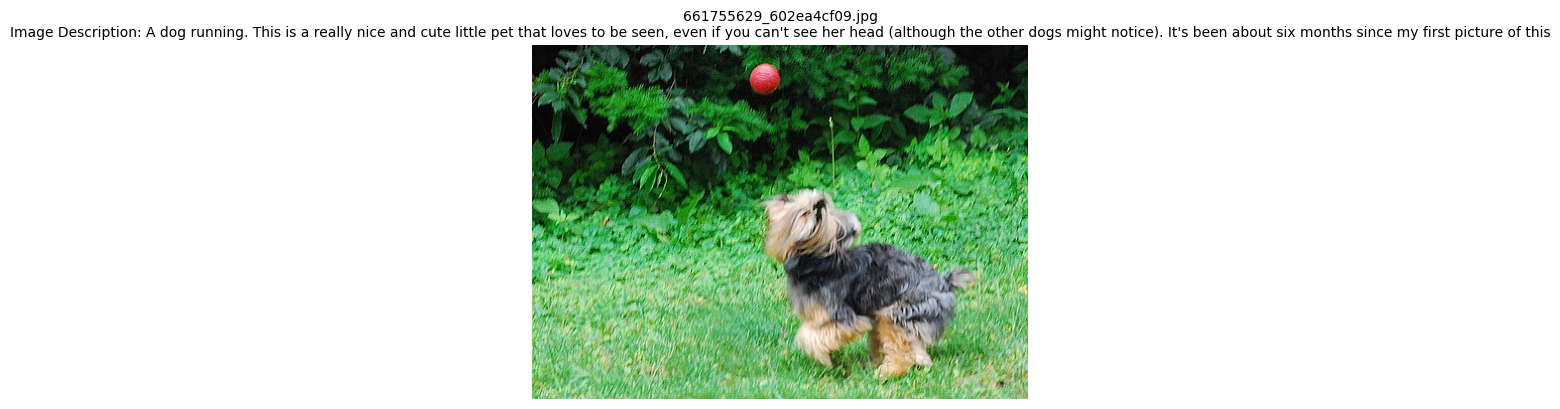

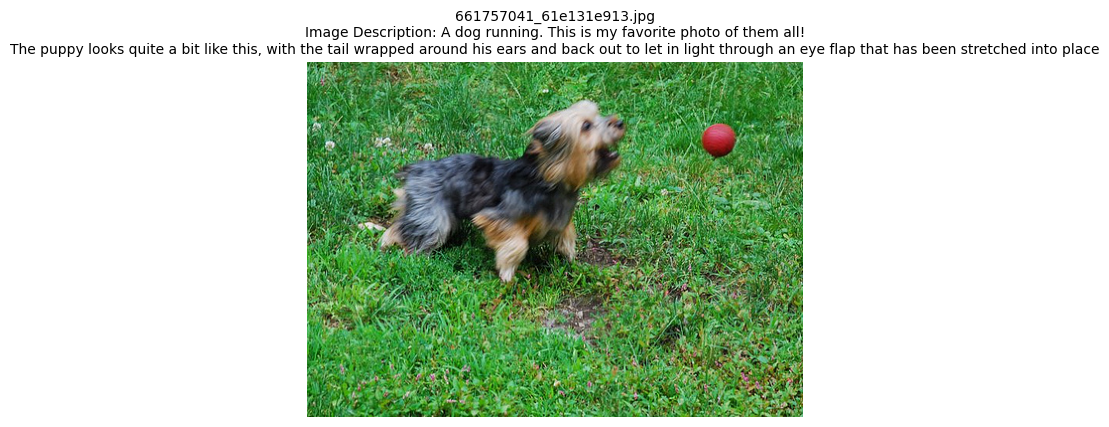

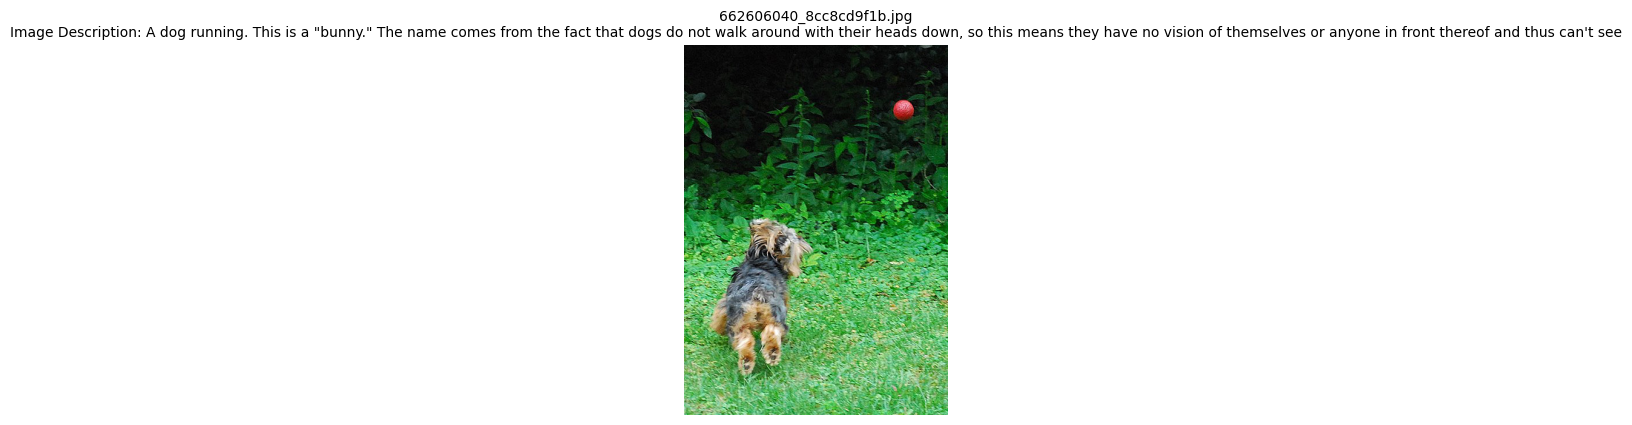

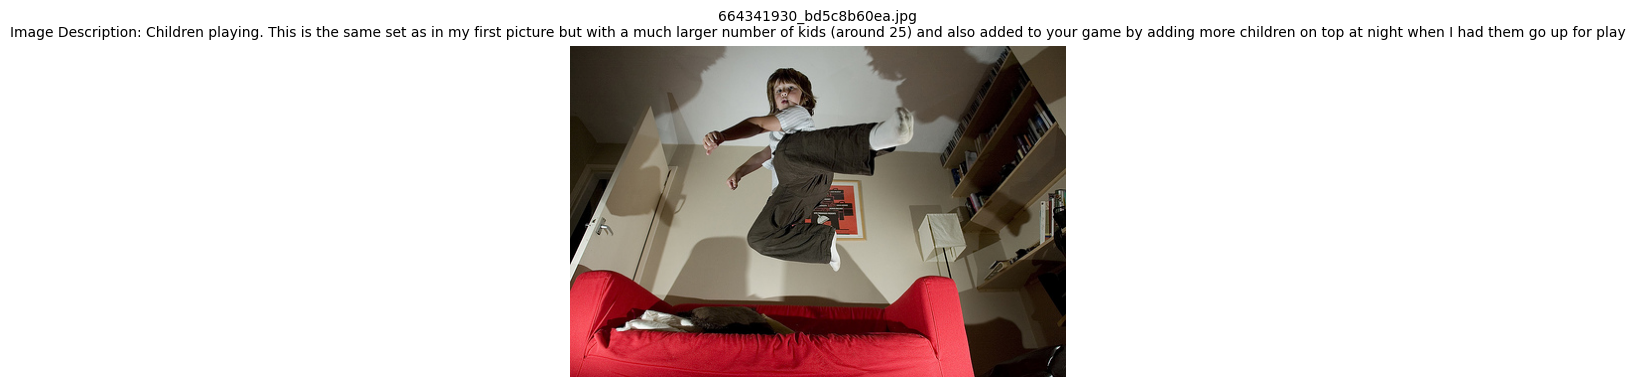

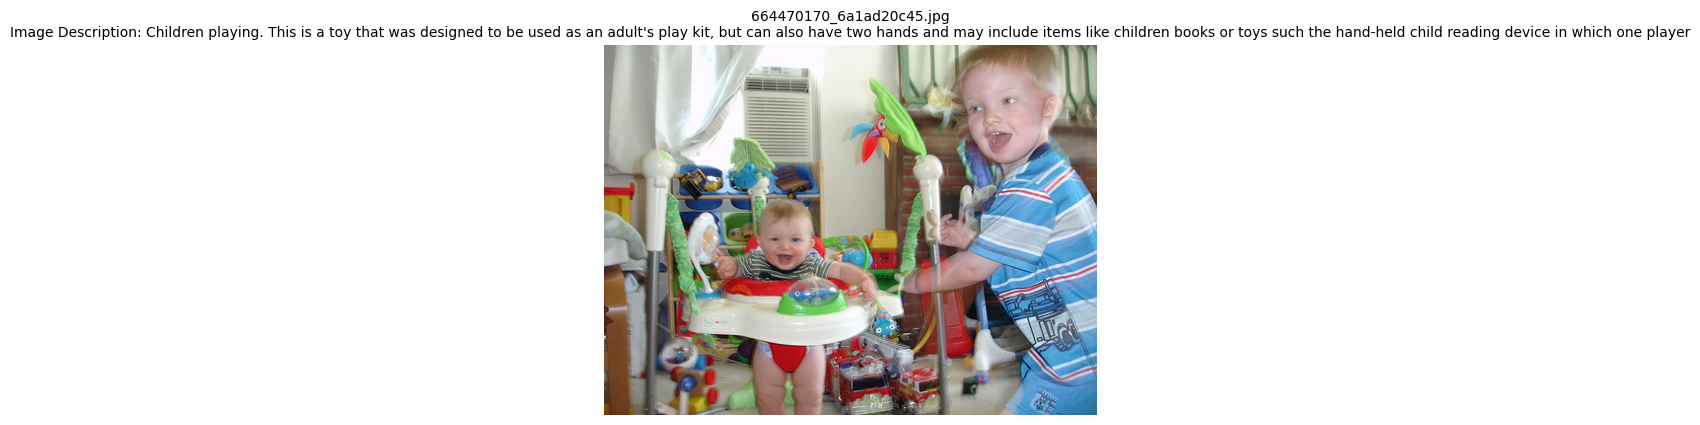

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# مسار ملف النتائج
checkpoint_file = "/content/drive/MyDrive/Flickr30/captions_generated.csv"
image_folder = "/content/drive/MyDrive/Flickr30/Images"

# قراءة الملف
df = pd.read_csv(checkpoint_file)

# أخذ أول 5 عينات
sample_df = df.head(5)

# عرض النتائج
for idx, row in sample_df.iterrows():
    image_name = row["image"]
    caption = row["caption"]
    image_path = os.path.join(image_folder, image_name)

    if os.path.exists(image_path):
        img = Image.open(image_path).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{image_name}\n{caption}", fontsize=10)
        plt.show()
    else:
        print(f"⚠️ الصورة {image_name} غير موجودة في {image_folder}")


In [ ]:
import pandas as pd

# مسار ملف النتائج
checkpoint_file = "/content/drive/MyDrive/Flickr30/captions_generated.csv"

# قراءة الملف
df = pd.read_csv(checkpoint_file)

# أخذ أول 5 قصص
sample_df = df.head(5)

# عرض النتائج
for i, row in sample_df.iterrows():
    print(f"📌 الصورة: {row['image']}")
    print(f"📝 القصة: {row['caption']}\n")


📌 الصورة: 661755629_602ea4cf09.jpg
📝 القصة: Image Description: A dog running. This is a really nice and cute little pet that loves to be seen, even if you can't see her head (although the other dogs might notice). It's been about six months since my first picture of this

📌 الصورة: 661757041_61e131e913.jpg
📝 القصة: Image Description: A dog running. This is my favorite photo of them all!
The puppy looks quite a bit like this, with the tail wrapped around his ears and back out to let in light through an eye flap that has been stretched into place

📌 الصورة: 662606040_8cc8cd9f1b.jpg
📝 القصة: Image Description: A dog running. This is a "bunny." The name comes from the fact that dogs do not walk around with their heads down, so this means they have no vision of themselves or anyone in front thereof and thus can't see

📌 الصورة: 664341930_bd5c8b60ea.jpg
📝 القصة: Image Description: Children playing. This is the same set as in my first picture but with a much larger number of kids (around 25) 

📊 إحصائيات:
count    8090.000000
mean       41.566378
std         4.390209
min        12.000000
25%        40.000000
50%        43.000000
75%        44.000000
max        48.000000
Name: word_count, dtype: float64


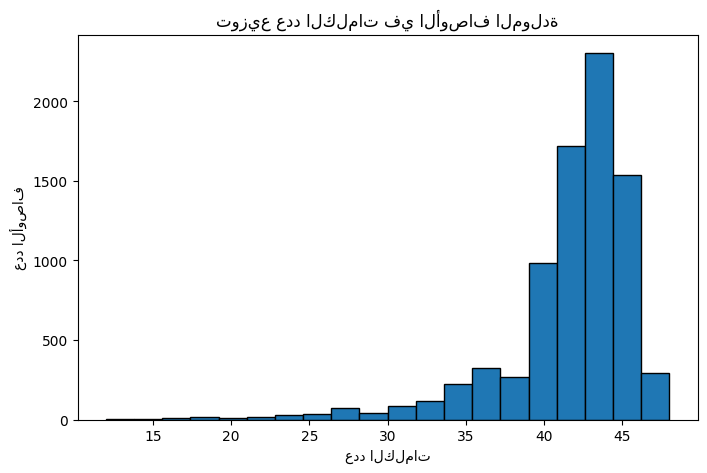

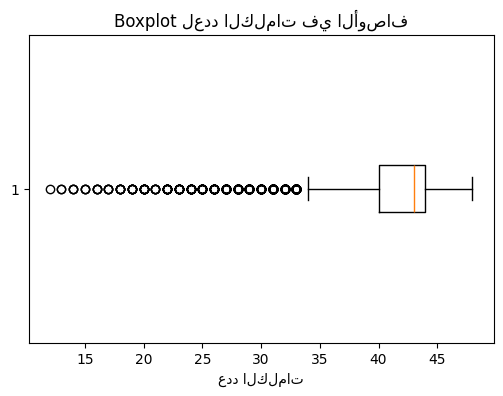

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# تحميل الملف
checkpoint_file = "/content/drive/MyDrive/Flickr30/captions_generated.csv"
df = pd.read_csv(checkpoint_file)

# حساب طول كل وصف (عدد الكلمات)
df["word_count"] = df["caption"].apply(lambda x: len(str(x).split()))

# عرض إحصائيات عامة
print("📊 إحصائيات:")
print(df["word_count"].describe())

# رسم histogram لتوزيع عدد الكلمات
plt.figure(figsize=(8,5))
plt.hist(df["word_count"], bins=20, edgecolor="black")
plt.title("توزيع عدد الكلمات في الأوصاف المولدة")
plt.xlabel("عدد الكلمات")
plt.ylabel("عدد الأوصاف")
plt.show()

# رسم boxplot لرؤية القيم المتطرفة
plt.figure(figsize=(6,4))
plt.boxplot(df["word_count"], vert=False)
plt.title("Boxplot لعدد الكلمات في الأوصاف")
plt.xlabel("عدد الكلمات")
plt.show()


In [ ]:
import pandas as pd

# تحميل الملف
checkpoint_file = "/content/drive/MyDrive/Flickr30/captions_generated.csv"
df = pd.read_csv(checkpoint_file)

# دالة لإرجاع القصص المولدة لصورتين
def get_captions_for_images(image1, image2):
    results = {}
    for img in [image1, image2]:
        row = df[df["image"] == img]
        if not row.empty:
            results[img] = row["caption"].values[0]
        else:
            results[img] = "❌ لم يتم توليد وصف لهذه الصورة بعد."
    return results

# مثال: ضع أسماء الصور (مع الامتداد)
image1_name = "439492931_a96d590e40.jpg"
image2_name = "494907021_321e82877a.jpg"

captions = get_captions_for_images(image1_name, image2_name)

# عرض النتائج
for img, cap in captions.items():
    print(f"{img} ➜ {cap}\n")


439492931_a96d590e40.jpg ➜ Image Description: A dog running. This is the first time it has been seen outside our house, and we were surprised to see all these animals around by ourselves in this picture above!
There are also a number of pictures showing dogs that have left

494907021_321e82877a.jpg ➜ Image Description: Children playing. This is a 4D character animation which makes it difficult to identify characters in the middle of their screen, but helps keep you visually distracted from any distracting background image that's already up there!
The images are generated by

